In [23]:
import matplotlib.pyplot as plt 
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os

# MNIST

## Подготовим данные.

In [24]:
!rm -rf mnist.pkl.gz mnist.pkl

!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9.9M  100  9.9M    0     0  8615k      0  0:00:01  0:00:01 --:--:-- 8608k


In [25]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

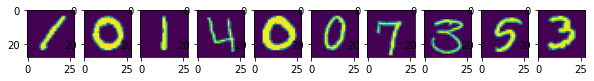

In [26]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(data[i].reshape(28,28))
pylab.show()

In [27]:
n = 42000

# Разбиваем на обучающую и тестовые выборки
train_x, test_x = np.split(data, [n*8//10])
train_labels, test_labels = np.split(labels, [n*8//10])

## Основные функции и классы

In [28]:
class Net:
    
    def __init__(self, loss_function, alg):
        self.layers = []
        self.alg = alg
        self.loss = loss_function()
    
    def add(self, l):
        self.layers.append(l)
        
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self, lr):
        self.alg.update(self, lr)
    
    def forward_loss(self, p, y):
        return self.loss.forward(p, y)
    
    
    def backward_loss(self, loss):
        return self.loss.backward(loss)
         
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.forward_loss(p, y)
        pred = np.argmax(p, axis = 1)
        acc = (pred == y).mean()
        return l, acc
    
    def train_epoch(self, train_x, train_labels, batch_size, lr):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            #Метод наискорейшего градиентного спуска
            l = 0.5
            r = 400
            
            while(r - l < 0.000001):
                a = l + (r - l) / 3
                b = l + 2 * (r - l) / 3
                net.update(lr * a)
                p = self.forward(xb)
                fa = self.forward_loss(p, yb)
                net.update(- lr * a)
                
                net.update(lr * b)
                p = self.forward(xb)
                fb = self.forward_loss(p, yb)
                net.update(- lr * b)
                
                if fb > fa:
                    r = b
                else:
                    l = a
            
            
            p = self.forward(xb)
            loss = self.forward_loss(p, yb)
            dp = self.backward_loss(loss)    
            dx = self.backward(dp)
            net.update(lr * l)
        
    def train(self, n_epoch, train_x, train_labels, test_x, test_labels, batch_size, lr):
        graphics = [[], []]
        for i in range(n_epoch):
            self.train_epoch(train_x, train_labels, batch_size, lr)
            train_loss, train_acc = net.get_loss_acc(train_x, train_labels)
            test_loss, test_acc = net.get_loss_acc(test_x, test_labels)
            graphics[0].append(train_acc)
            graphics[1].append(test_acc)
        return graphics
            
    def draw_confusion_matrix_and_graphics(self, x, labels, n, graphics):
        p = self.forward(x)
        res = np.argmax(p, axis = 1)
        con_matrix = []
        for i in range(n):
            con_matrix.append([0]*n)
            
        for i in range(len(res)):
            con_matrix[res[i]][labels[i]] += 1
            
        figure = plt.figure(figsize = (17, 5))
        axes = figure.add_subplot(121)
        caxes = axes.matshow(con_matrix)
        figure.colorbar(caxes)
        
        axes = figure.add_subplot(122)
        plt.plot(graphics[0], 'r')
        plt.plot(graphics[1], 'b')
        plt.show()

class Gradient_Descent:
    
    def update(net, lr):
        for l in net.layers:
            if 'update' in l.__dir__():
                l.update(lr)
class Linear:
    def __init__(self, nin, nout):
        self.W = np.random.normal(0, 1.0 / np.sqrt(2 * nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis = 0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis = 1,keepdims = True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis = 1,keepdims = True)
        return expz / Z
    
    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis = 1, keepdims = True)
class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p
class MeanSquareError:
    def forward(self, p, y):
        self.p = p
        self.y = y
        
        sum = 0
        for i in range(len(p)):
            for j in range(len(p[i])):
                if j == y[i]:
                    sum += (p[i][j] - 1) ** 2
                else:
                    sum += p[i][j] ** 2
        return sum 
        
    def backward(self, loss):
        sum = np.zeros(self.p.shape)
        for i in range(len(self.p)):
            for j in range(len(self.p[i])):
                if j == self.y[i] :
                    sum[i][j] += 2.0 * (self.p[i][j] - 1)
                else:
                    sum[i][j] += 2.0 * self.p[i][j]
        return sum

class Tanh:
    def forward(self, x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self, dy):
        return (1.0 - self.y ** 2) * dy

class ReLU:
    def forward(self, x):
        self.y = x
        self.y[self.y < 0] = 0
        return self.y
    def backward(self, dy):
        self.y[self.y > 0] = 1
        return self.y * dy

## Однослойная сеть

Количество эпох - 10

Размер батча - 4

Шаг градиента - 0.0000075

Функция ошибки - CrossEntropyLoss

Initial loss=89.57090981543332, accuracy=0.052708333333333336: 


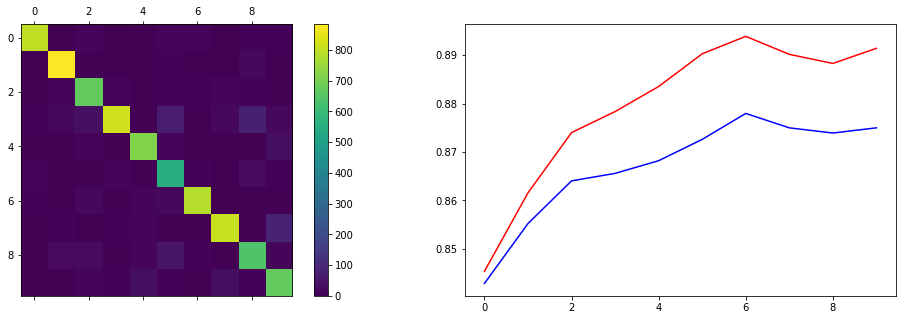

Final loss=1.2588275772575144, accuracy=0.8914285714285715: 
Test loss=1.6540218533560338, accuracy=0.875: 


In [31]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(10, train_x, train_labels, test_x, test_labels, 4, 0.0000075)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 10

Размер батча - 20

Шаг градиента - 0.00008

Функция ошибки - CrossEntropyLoss

Initial loss=128.3628611007415, accuracy=0.09428571428571429: 


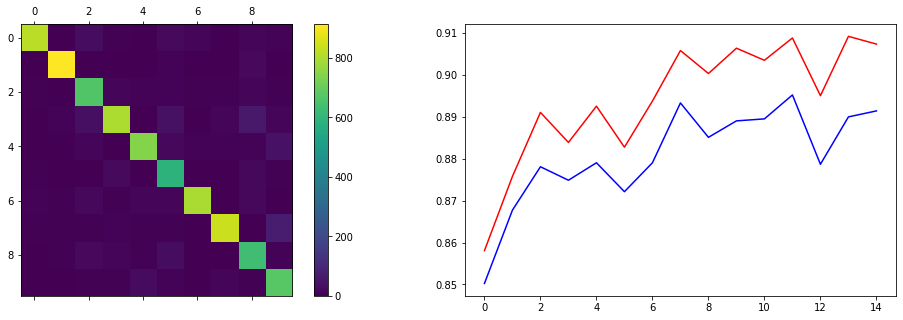

Final loss=1.143390000117673, accuracy=0.9073809523809524: 
Test loss=1.6585926052257214, accuracy=0.8914285714285715: 


In [35]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(15, train_x, train_labels, test_x, test_labels, 20, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 20

Размер батча - 10

Шаг градиента - 0.0001

Функция ошибки - MeanSquareError

Initial loss=57659.678446482394, accuracy=0.1293154761904762: 


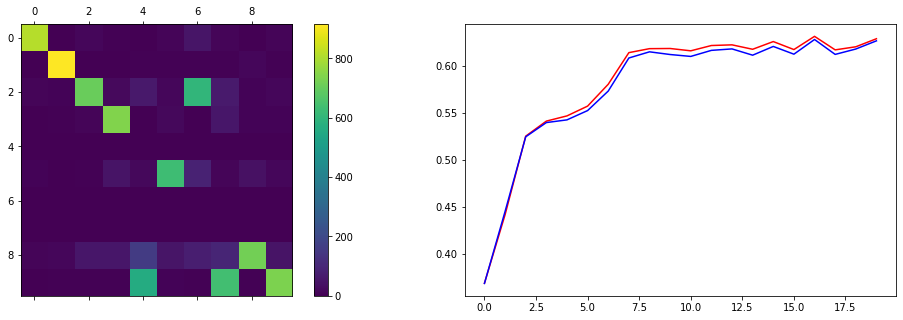

Final loss=24889.96234701951, accuracy=0.6287797619047619: 
Test loss=6259.241916539453, accuracy=0.626547619047619: 


In [9]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(20, train_x, train_labels, test_x, test_labels, 10, 0.0001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 50

Размер батча - 2

Шаг градиента - 0.000001

Функция ошибки - MeanSquareError

Initial loss=59935.554790501505, accuracy=0.09565476190476191: 


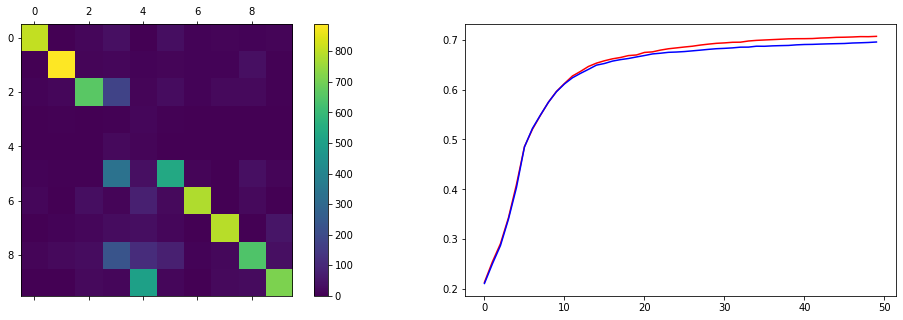

Final loss=19335.222436637974, accuracy=0.7069345238095238: 
Test loss=5019.393898436403, accuracy=0.695595238095238: 


In [10]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(50, train_x, train_labels, test_x, test_labels, 2, 0.000001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

## Многослойная сеть

Количество эпох - 10

Размер батча - 1

Количество слоёв - 2

Шаг градиента - 0.000008

Функция ошибки - CrossEntropyLoss

Предаточная функция - Tanh

Initial loss=2.587812044681138, accuracy=0.06949404761904762: 


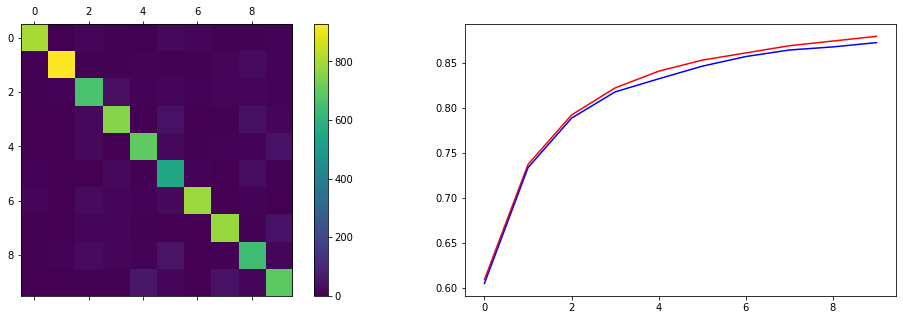

Final loss=0.5406329864922658, accuracy=0.8791071428571429: 
Test loss=0.5526539832790596, accuracy=0.8721428571428571: 


In [11]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 128))
net.add(Tanh())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 1, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 10

Размер батча - 5

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - MeanSquareError

Предаточная функция - Tanh

Initial loss=2.391476891518552, accuracy=0.078125: 


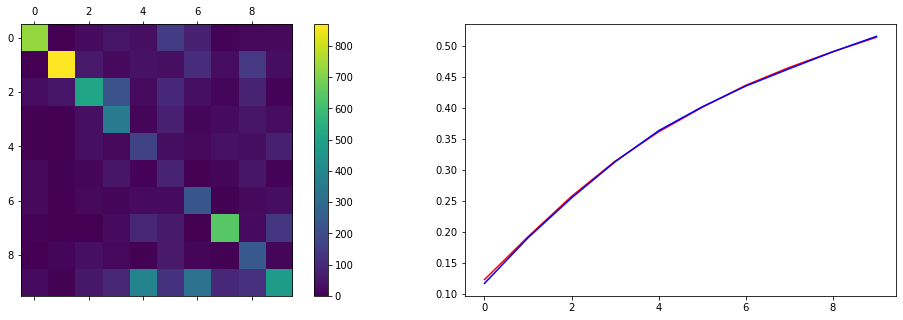

Final loss=1.819422342604207, accuracy=0.5141666666666667: 
Test loss=1.8172971248387928, accuracy=0.5155952380952381: 


In [12]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 64))
net.add(Tanh())
net.add(Linear(64, 32))
net.add(Tanh())
net.add(Linear(32, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 5, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 10

Размер батча - 20

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - CrossEntropyLoss

Предаточная функция - ReLu

Initial loss=45.70541159746019, accuracy=0.09041666666666667: 


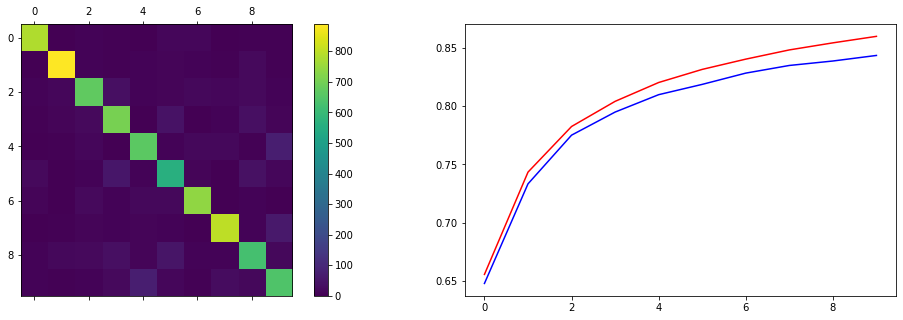

Final loss=1.1732711035762045, accuracy=0.8595535714285715: 
Test loss=1.2863462244490569, accuracy=0.8432142857142857: 


In [13]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x,train_labels)))

graphics =  net.train(10, train_x, train_labels, test_x, test_labels, 20, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 25

Размер батча - 4

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - MeanSquareError

Предаточная функция - ReLu

Initial loss=57364.84685672799, accuracy=0.06294642857142857: 


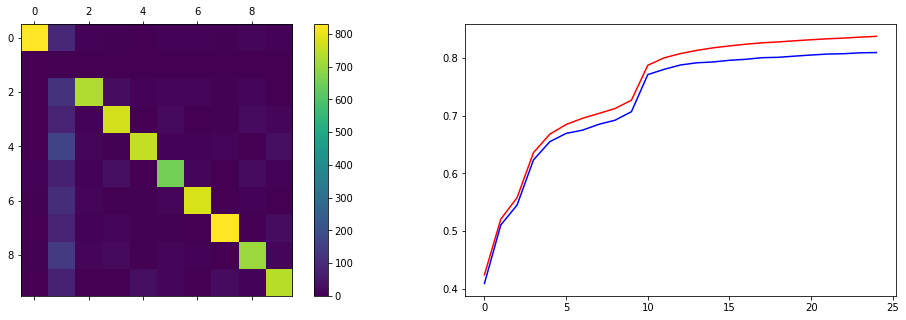

Final loss=7865.421494922582, accuracy=0.8373214285714285: 
Test loss=2300.010262049549, accuracy=0.8092857142857143: 


In [14]:
net = Net(MeanSquareError, Gradient_Descent)
net.add(Linear(784, 100))
net.add(ReLU())
net.add(Linear(100, 96))
net.add(ReLU())
net.add(Linear(96, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x,train_labels)))

graphics =  net.train(25, train_x, train_labels, test_x, test_labels, 4, 0.000008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

# FashionMNIST

## Подготовим данные

In [15]:
!rm -rf *.gz

!curl -o test-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
!curl -o test-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-labels-idx1-ubyte.gz
!curl -o train-images.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
!curl -o train-labels.gz https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-labels-idx1-ubyte.gz

import gzip
with gzip.open("test-labels.gz", "rb") as gz:
    test_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("test-images.gz", "rb") as gz:
    test_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)
    
with gzip.open("train-labels.gz", "rb") as gz:
    train_labels = np.frombuffer(gz.read(), dtype=np.uint8, offset=8)
with gzip.open("train-images.gz", "rb") as gz:
    train_x = np.frombuffer(gz.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  18.8M      0 --:--:-- --:--:-- --:--:-- 18.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  41853      0 --:--:-- --:--:-- --:--:-- 41853
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  80.7M      0 --:--:-- --:--:-- --:--:-- 80.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   218k      0 --:--:-- --:--:-- --:--:--  218k


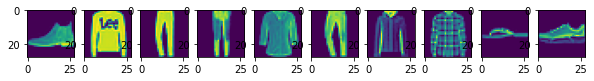

In [16]:
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(test_x[i].reshape(28,28))
pylab.show()

Количество эпох - 15

Размер батча - 20

Количество слоёв - 1

Шаг градиента - 0.00008

Функция ошибки - CrossEntropyLoss

Initial loss=120.84752266586396, accuracy=0.0979: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in true_divide


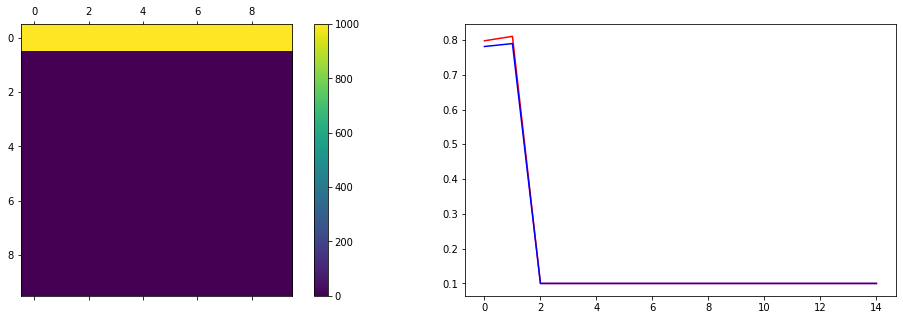

Final loss=nan, accuracy=0.1: 
Test loss=nan, accuracy=0.1: 


In [17]:
net = Net(CrossEntropyLoss, Gradient_Descent)
net.add(Linear(784,10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = [[], []]
graphics = net.train(15, train_x, train_labels, test_x, test_labels, 20, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)
    
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 20

Размер батча - 2

Количество слоёв - 3

Шаг градиента - 0.000008

Функция ошибки - MeanSquareError

Предаточная функция - Tanh

Initial loss=55315.67307060903, accuracy=0.11573333333333333: 


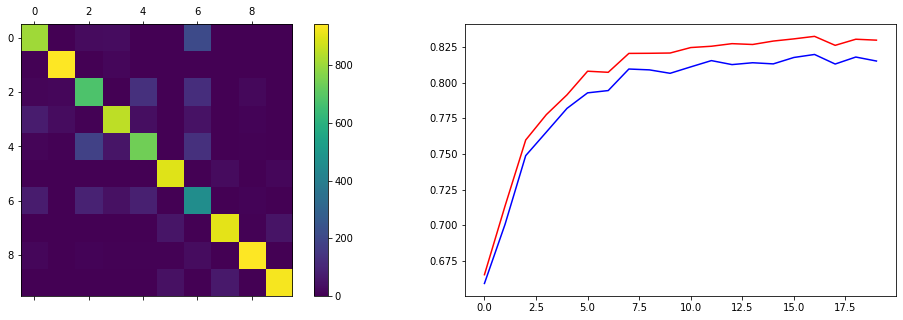

Final loss=15398.807904963385, accuracy=0.8297333333333333: 
Test loss=2736.72643810134, accuracy=0.8151: 


In [18]:
net = Net(MeanSquareError, Gradient_Descent)

net.add(Linear(784, 128))
net.add(Tanh())
net.add(Linear(128, 32))
net.add(Tanh())
net.add(Linear(32, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(20, train_x, train_labels, test_x, test_labels, 2, 0.00008)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))

Количество эпох - 10

Размер батча - 6

Количество слоёв - 3

Шаг градиента - 0.00001

Функция ошибки - CrossEntropyLoss

Предаточная функция - ReLU

Initial loss=34.85191537393579, accuracy=0.16388333333333333: 


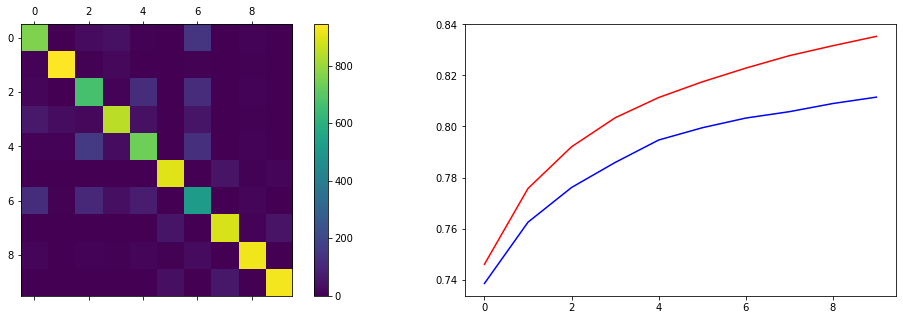

Final loss=0.5043809735348076, accuracy=0.8353166666666667: 
Test loss=0.5748714230706612, accuracy=0.8115: 


In [19]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 196))
net.add(ReLU())
net.add(Linear(196, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 6, 0.00001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))


Количество эпох - 10

Размер батча - 6

Количество слоёв - 3

Шаг градиента - 0.00001

Функция ошибки - CrossEntropyLoss

Предаточная функция - Tanh

Initial loss=2.3106880084047736, accuracy=0.14978333333333332: 


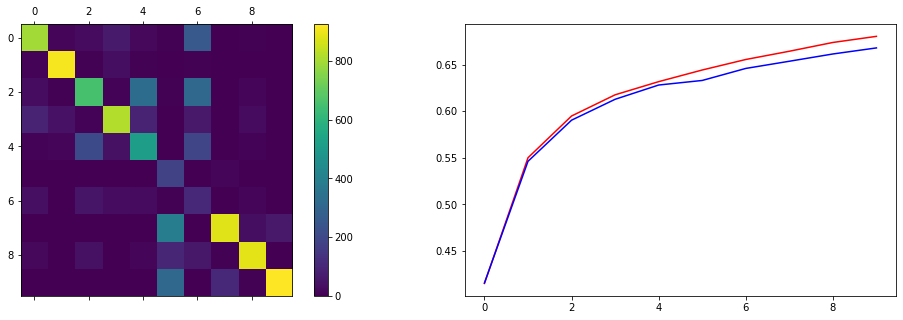

Final loss=1.1967022181212537, accuracy=0.6802: 
Test loss=1.2100466408389239, accuracy=0.6678: 


In [20]:
net = Net(CrossEntropyLoss, Gradient_Descent)

net.add(Linear(784, 200))
net.add(Tanh())
net.add(Linear(200, 150))
net.add(Tanh())
net.add(Linear(150, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))

graphics = net.train(10, train_x, train_labels, test_x, test_labels, 6, 0.00001)
net.draw_confusion_matrix_and_graphics(test_x, test_labels, 10, graphics)

print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(train_x, train_labels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(test_x, test_labels)))